In [1]:
%pylab inline
import pandas as pd
from scipy.optimize import curve_fit
from scipy import asarray as ar
from scipy import math
import pylandau
import random

Populating the interactive namespace from numpy and matplotlib


# Importo il dataset

In [2]:
file = pd.read_csv(r'/home/gdeandrea/Scrivania/UNI/Econofisica/MyModels/Epstein/PRESE DATI/A-Valore Soglia/dati_rivolte_long')
file.head()

,x,y,color,pen down?,x.1,y.1,color.1,pen down?.1,x.2,y.2,color.2,pen down?.2
0,595,938,55,True,595,181,0,True,595,1,15,True
1,596,955,55,True,596,164,0,True,596,1,15,True
2,597,972,55,True,597,146,0,True,597,2,15,True
3,598,988,55,True,598,132,0,True,598,0,15,True
4,599,996,55,True,599,114,0,True,599,10,15,True


In [3]:
df = file['y.2']
y = df.to_numpy()
y = y[220:]
x = ar(range(len(y)))

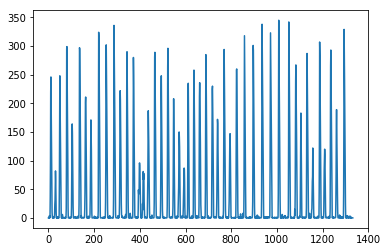

In [4]:
plt.plot(x,y)

# Definizioni Utili

## Fit Utils

In [5]:
def chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit[i])
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

def cost_chiquadronorm(oss, fit, sigma, ddof, aiuto=False, norm=True):
    'funzione che calcola il chiquadrato di una distribuzione osservata rispetto a una\
    forma funzionale nota'
    
    #prende liste monodimensionali come argomenti
    scarti = []
    scartiquadri = []
    scartiquadridivisi = []
    
    for i in range(len(oss)):
        scarti.append(oss[i]-fit)
        scartiquadri.append(scarti[i]*scarti[i])
        scartiquadridivisi.append(scartiquadri[i]/(sigma[i]*sigma[i]))
        
        if (aiuto==True):
            print('scarti= ', scarti[i])
            print('scartiquadri= ', scartiquadri[i])
            print('scartiquadridivisi= ', scartiquadridivisi[i])
            
    chiquadro=sum(scartiquadridivisi)
    chiquadroreg=chiquadro/ddof
    
    if(norm==True):
        return (chiquadroreg)
    else:
        return (chiquadro)

    
def media_pesata(x, sigma):
    numeratore = 0
    denominatore = 0
    for i in range(len(x)):
        numeratore += x[i]/(sigma[i]**2)
        denominatore += 1/(sigma[i]**2)
    return numeratore/denominatore

def costante(x,q):
    return q

def retta(x,m,q):
    return m*x +q

def gauss(x,a,x0,sigma,baseline):
    'Ritorna array gaussiano a partire da lista x secondo i parametri a,x0,sigma'
    return (baseline + a*exp(-(x-x0)**2/(2*sigma*sigma)))


def lore(x, a, x0, y0, baseline):
    'Ritorna array lorentziano a partire da lista x secondo i parametri a,x0,yo'
    return (baseline + a*(y0/(((x - x0)**2) + (y0**2))))

def fattoriale(x):
    temp_list = []

    for ics in x:
        f=1
        for i in range(1,ics+1):
            f*=i
        temp_list.append(f)
    return(temp_list)

def poisson(x, a, media, baseline):
    result = baseline + a*(media**x)*np.exp(-media)/fattoriale(x)
    return(result)

def landau(x, mpv, eta, A, baseline):
    x=double(x)
    'Ritorna array landauiano a partire da lista x secondo i parametri suoi'
    return (baseline + double(pylandau.landau(x, mpv=mpv, eta=eta, A=A)))

## Findings of previous step

In [6]:
soglia = 128.1241472701187
err_soglia = 11.6007119219633

## Selecting Spikes

In [7]:
def isola_spikes (y, datiesterni):
    '''
    Dati i dati sugli attivi, ritorna due dizionari: 
    {num_rivolta: [valori attivi]}
    {num_rivolta: [tick corrispondenti]}
    '''
    rivolte_diz = {}
    tick_rivolte_diz = {}
    temp_rivolta_list = []
    temp_tick_list = []
    rivolte_counter = 0
    cerarivolta = False
    
    for i in range(len(y)):
        
        ##aggiustato a 12 per non avere rivoltini
        if y[i] > 12:
            temp_rivolta_list.append(y[i])
            temp_tick_list.append(i)
            if cerarivolta == False:
                rivolte_counter += 1
                cerarivolta = True
        else:
            if cerarivolta == True:
                lunghezza=len(temp_rivolta_list)
                if rivolte_counter > 1:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, y[i-lunghezza-1])
                        temp_rivolta_list.insert(0, y[i-lunghezza-2])
                        temp_rivolta_list.insert(0, y[i-lunghezza-3])
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                else:
                    if datiesterni == 1:
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                    if datiesterni == 2:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                    if datiesterni == 3:
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_rivolta_list.insert(0, 0)
                        temp_tick_list.insert(0, i-lunghezza-1)
                        temp_tick_list.insert(0, i-lunghezza-2)
                        temp_tick_list.insert(0, i-lunghezza-3)
                    
                if datiesterni == 1:
                        temp_rivolta_list.append(y[i])
                        temp_tick_list.append(i)
                if datiesterni == 2:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                if datiesterni == 3:
                        temp_rivolta_list.append(y[i])
                        temp_rivolta_list.append(y[i+1])
                        temp_rivolta_list.append(y[i+2])
                        temp_tick_list.append(i)
                        temp_tick_list.append(i+1)
                        temp_tick_list.append(i+2)
                
                rivolte_diz[str(rivolte_counter)+'_spike'] = temp_rivolta_list
                tick_rivolte_diz[str(rivolte_counter)+'_spike'] = temp_tick_list
                temp_rivolta_list = []
                temp_tick_list = []
                cerarivolta = False
                
    return rivolte_diz, tick_rivolte_diz

# Analisi

## Creo dizionario degli spikes

In [8]:
spikes_dict, spikes_tick_dict = isola_spikes(y, 3)

## Seleziono rivolte in base a valore di soglia trovato precedentemente

In [9]:
## If soglia-errore_soglia < y + errore_y --> rivolta
rivolte_dict = {}
rivoltini_dict = {}
tick_rivolte_dict = {}
tick_rivoltini_dict = {}
rivolte_counter = 0
rivoltini_counter = 0
for spike in spikes_dict:
    y = spikes_dict[spike]
    x = spikes_tick_dict[spike]
    if np.max(y)+np.sqrt(np.max(y)) >= soglia-err_soglia:
        rivolte_counter += 1
        rivolte_dict[str(rivolte_counter)+'_rivolta']=y
        tick_rivolte_dict[str(rivolte_counter)+'_rivolta']=x
    else:
        rivoltini_counter += 1
        rivoltini_dict[str(rivoltini_counter)+'_rivolta']=y
        tick_rivoltini_dict[str(rivoltini_counter)+'_rivolta']=x

## Calcolo Metriche: Durata, tempi d'attesa e ampiezza  
Tutte le metriche vengono ricavate dal calcolo dei parametri derivanti dalla procedura di fit:  
- Durata = 6sigma della rivolta considerata  
- Tempo attesa = (media[rivolta_i+1] - 3sigma[rivolta_i+1]) - (media[rivolta_i] + 3sigma[rivolta_i])  
- Ampiezza = parametro del fit  
  
Gli errori vengono calcolati dalla propagazione degli errori sui parametri del fit

In [10]:
## For loop che mi serve a trovare ampiezza, media e deviazione standard di ognuna delle rivolte,
###salvo i parametri del fit per ognuna delle rivolte
gauss_params_dict = {}
gauss_err_params_dict = {}
for rivolte in rivolte_dict:
    print(rivolte)
    temp_list = []
    temp_err_list = []
    y = rivolte_dict[rivolte]
    x = tick_rivolte_dict[rivolte]
    
    
    err_y = np.where(np.sqrt(y)==0,1,np.sqrt(y))
    gauss_params,gauss_cov = curve_fit(gauss,x,y,p0=[200,((x[-1]-x[0])/2)+x[0],4.,0.],sigma=err_y)
    temp_list.append(gauss_params[0])
    temp_list.append(gauss_params[1])
    temp_list.append(gauss_params[2])
    temp_list.append(gauss_params[3])
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[0][0])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[1][1])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[2][2])))
    temp_err_list.append(np.sqrt(np.abs(gauss_cov[3][3])))
    gauss_params_dict[rivolte] = temp_list
    gauss_err_params_dict[rivolte] = temp_err_list

1_rivolta
2_rivolta
3_rivolta
4_rivolta
5_rivolta
6_rivolta
7_rivolta
8_rivolta
9_rivolta
10_rivolta
11_rivolta
12_rivolta
13_rivolta
14_rivolta
15_rivolta
16_rivolta
17_rivolta
18_rivolta
19_rivolta
20_rivolta
21_rivolta
22_rivolta
23_rivolta
24_rivolta
25_rivolta
26_rivolta
27_rivolta
28_rivolta
29_rivolta
30_rivolta
31_rivolta
32_rivolta
33_rivolta
34_rivolta
35_rivolta
36_rivolta
37_rivolta
38_rivolta
39_rivolta
40_rivolta
41_rivolta
42_rivolta
43_rivolta
44_rivolta


### Durata

In [11]:
## calcolo la durata delle singole rivolte come 6 per la sigma della rivolta (hp:gaussiane)
###e errori su singole durate propagando gli errori sulla sigma (6*err_assoluto sigma)
durate_list = [gauss_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
err_durate_list = [gauss_err_params_dict[rivolte][2]*6 for rivolte in rivolte_dict]
durate_list = np.abs(durate_list)
err_durate_list = np.abs(err_durate_list)

## calcolo media pesata e errore su media
media_pesata_durate = media_pesata(durate_list, err_durate_list)
err_media_pesata_durate = np.sqrt(np.sum((durate_list - media_pesata_durate)**2)/(len(durate_list)*(len(durate_list)-1)))

### Tempi attesa

In [12]:
## calcolo liste dei tick di inizio e fine rivolte con relativi errori 
###trovati con propagazione degli errori dagli errori dei parametri del fit
###(start = media-3sigma --> err_start = sqrt(err_media**2 + (3err_sigma)**2)
start_tick_list = []
end_tick_list = []
err_start_tick_list = []
err_end_tick_list = []

for rivolte in gauss_params_dict:
    media = gauss_params_dict[rivolte][1]
    sigma = np.abs(gauss_params_dict[rivolte][2])
    err_media = gauss_err_params_dict[rivolte][1]
    err_sigma = gauss_err_params_dict[rivolte][2]
    start_tick_list.append(media - 3*sigma)
    end_tick_list.append(media + 3*sigma)
    err_start_tick_list.append(np.sqrt(err_media**2 + (3*err_sigma)**2))
    err_end_tick_list.append(np.sqrt(err_media**2 + (3*err_sigma)**2))

In [13]:
## Calcolo tempi di attesa dalle liste dei tick di inizio e fine rivolte e relativi errori
###calcolati con la propagazione dagli errori dei tick di inizio e fine rivolte
###(tempo_attesa = start[i+1]-end[i] --> err_tempo_attesa = sqrt(err_start[i+1]**2 + err_end[i]**2))
tempi_attesa_list = []
err_tempi_attesa_list = []
for i in range(len(end_tick_list)-1):
    tempi_attesa_list.append(start_tick_list[i+1] - end_tick_list[i])
    err_tempi_attesa_list.append(np.sqrt(err_start_tick_list[i+1]**2 + err_end_tick_list[i]**2))

In [14]:
## calcolo media pesata e errore su media
media_pesata_tempi_attesa = media_pesata(tempi_attesa_list, err_tempi_attesa_list)
err_media_pesata_tempi_attesa = np.sqrt(np.sum((tempi_attesa_list - media_pesata_tempi_attesa)**2)/(len(tempi_attesa_list)*(len(tempi_attesa_list)-1)))

### Ampiezza

In [15]:
## Calcolo ampiezze per ogni rivolta e errore da propagazione errori del fit
ampiezze_list = [gauss_params_dict[rivolte][0] for rivolte in rivolte_dict]
err_ampiezze_list = [gauss_err_params_dict[rivolte][0] for rivolte in rivolte_dict]
ampiezze_list = np.abs(ampiezze_list)
err_ampiezze_list = np.abs(err_ampiezze_list)

## Calcolo media pesata e errore su media
media_pesata_ampiezze = media_pesata(ampiezze_list, err_ampiezze_list)
err_media_pesata_ampiezze = np.sqrt(np.sum((ampiezze_list - media_pesata_ampiezze)**2)/(len(ampiezze_list)*(len(ampiezze_list)-1)))

### Re-plots

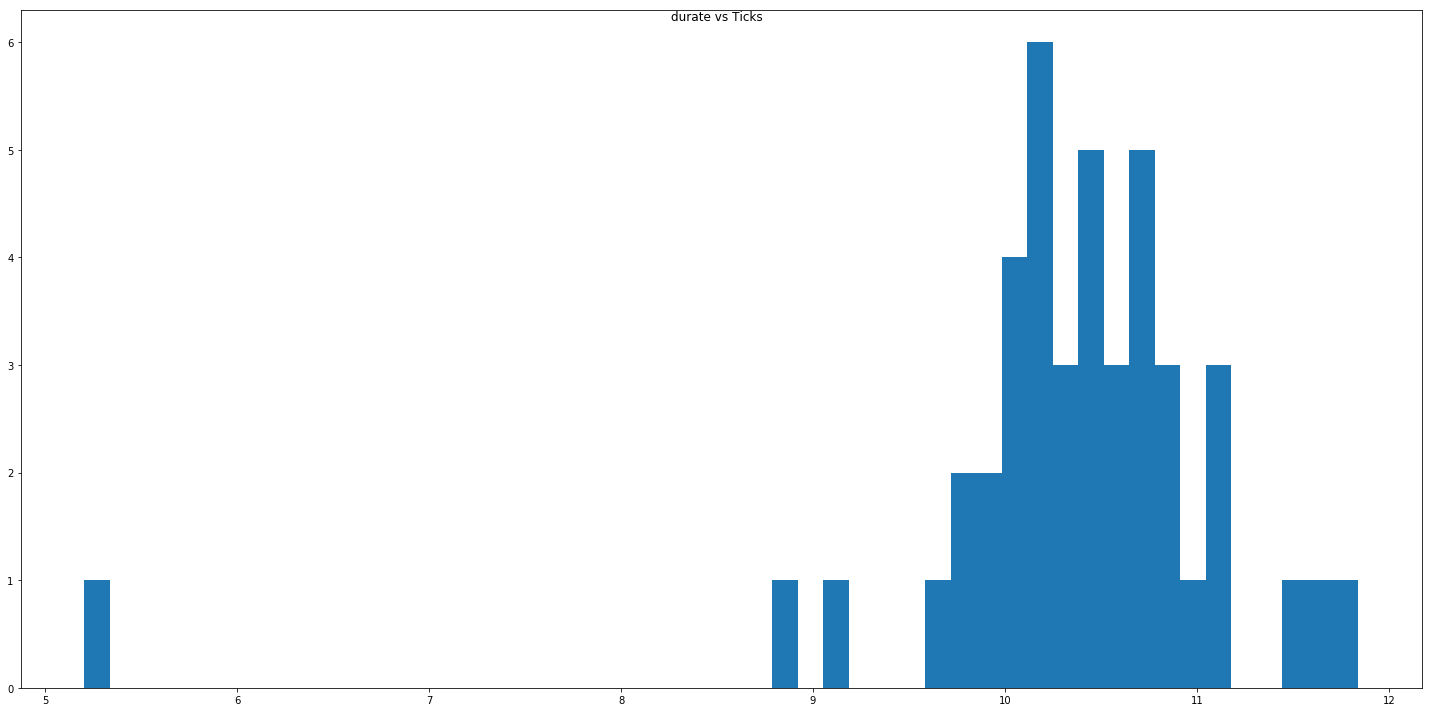

In [16]:
plt.figure(figsize=(20,10))
plt.hist(durate_list, bins=50)
plt.suptitle('durate vs Ticks')
plt.tight_layout()
plt.show()

In [17]:
print('Media pesata e errore durate',media_pesata(durate_list,err_durate_list),np.sqrt(np.sum((durate_list-media_pesata(durate_list,err_durate_list))**2)/(len(durate_list)*(len(durate_list)-1))))

Media pesata e errore durate 10.40410968107048 0.14837408685722145


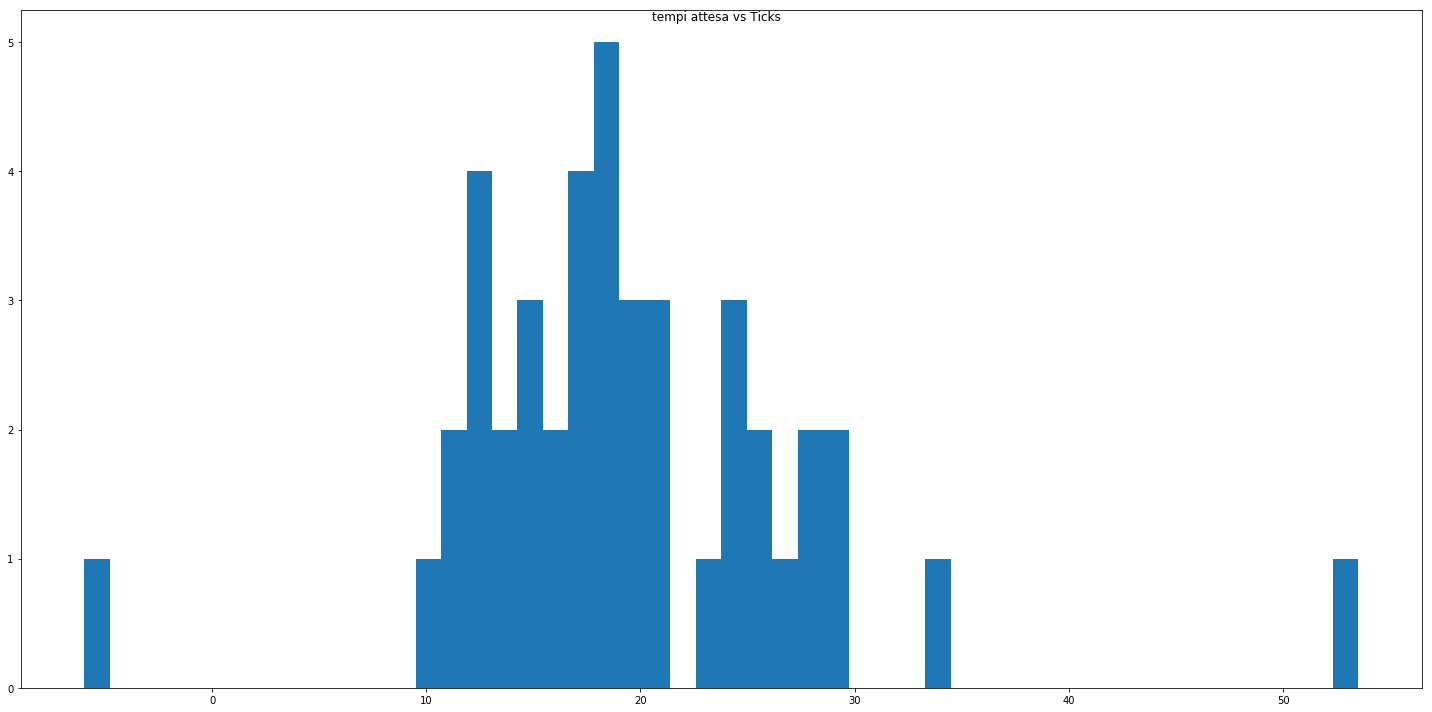

In [18]:
plt.figure(figsize=(20,10))
plt.hist(tempi_attesa_list, bins=50)
plt.suptitle('tempi attesa vs Ticks')
plt.tight_layout()
plt.show()

In [19]:
tempi_attesa_list = sort(tempi_attesa_list)
tempi_attesa_list = tempi_attesa_list[1:]

In [20]:
print('Media pesata e errore tempi attesa:',media_pesata(tempi_attesa_list,err_tempi_attesa_list),np.sqrt(np.sum((tempi_attesa_list-media_pesata(tempi_attesa_list,err_tempi_attesa_list))**2)/(len(tempi_attesa_list)*(len(tempi_attesa_list)-1))))

Media pesata e errore tempi attesa: 19.385250532044722 1.2115841148396387


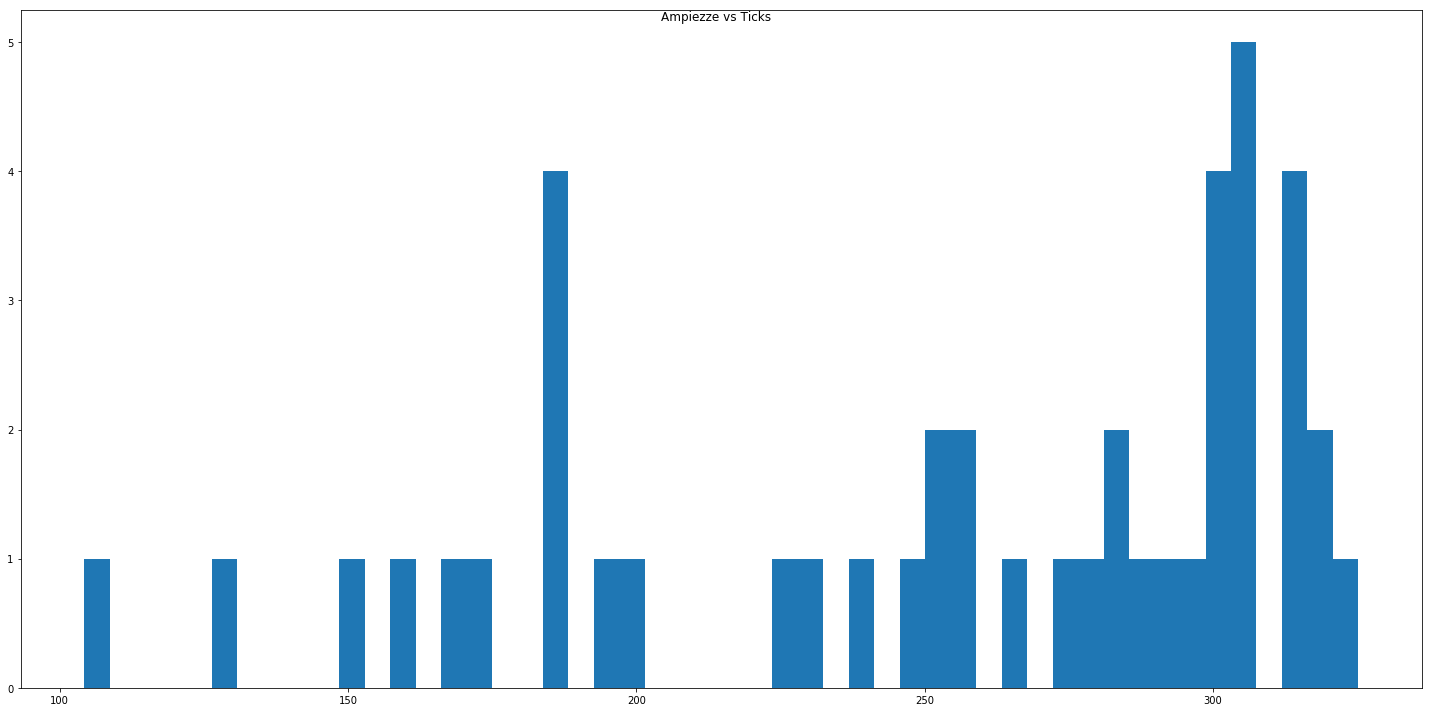

In [21]:
plt.figure(figsize=(20,10))
plt.hist(ampiezze_list, bins=50)
plt.suptitle('Ampiezze vs Ticks')
plt.tight_layout()
plt.show()

In [22]:
print('Media pesata e errore ampiezze:',media_pesata(ampiezze_list,err_ampiezze_list),np.sqrt(np.sum((ampiezze_list-media_pesata(ampiezze_list,err_ampiezze_list))**2)/(len(ampiezze_list)*(len(ampiezze_list)-1))))

Media pesata e errore ampiezze: 193.81577204215463 12.953383925225083


## Epstein - Tempi attesa  
Epstein afferma nel suo articolo che la distribuzione dei tempi di attesa per una rivolta segue un andamento a legge di potenza almeno nella coda destra della distribuzione, verifichiamolo

**Applico sturge's rule for binning**  
K = 1 + 3.322logN, K is num of bins, N is number of observations

In [23]:
N = len(tempi_attesa_list)
K = int(1 + 3.322*np.log(N))

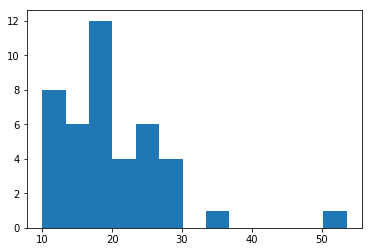

num_bin: 13  N: 42


In [24]:
counts, bins, bars = plt.hist(tempi_attesa_list, bins=K)
plt.show()
print('num_bin:', K, ' N:', N)

In [25]:
prova = tempi_attesa_list
prova = sort(prova)
len(prova)

42

In [26]:
prova = prova[:-1]
prova = prova[2:]
len(prova)

39

In [27]:
N = len(prova)
K = int(1 + 3.322*np.log(N))

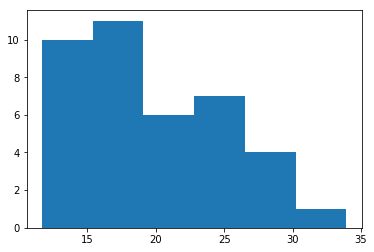

num_bin: 13  N: 39


In [28]:
counts, bins, bars = plt.hist(prova, bins=int(K/2.))
plt.show()
print('num_bin:', K, ' N:', N)

In [29]:
bin_values = [(bins[i]+bins[i+1])/2 for i in range(len(bins[1:]))]
err_counts = np.where(np.sqrt(counts)==0,1,np.sqrt(counts))/counts

In [30]:
counts

array([10., 11.,  6.,  7.,  4.,  1.])

**elimino gli ultimi sei valori, non considero l'ultimo outlier  
elimino il primo valore (come Epstein)**

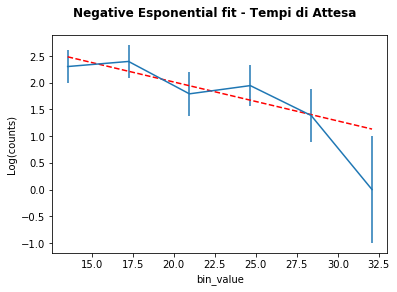

ReducedChiSquared: 0.6612266312469711


In [31]:
popt, pcov = curve_fit(retta, bin_values, np.log(counts), sigma=err_counts)
plt.suptitle('Negative Esponential fit - Tempi di Attesa', fontweight='bold')
plt.xlabel('bin_value')
plt.ylabel('Log(counts)')
plt.errorbar(bin_values, np.log(counts), yerr=err_counts)
plt.plot(bin_values, [retta(bin_values[i], *popt) for i in range(len(bin_values))], 'r--')
plt.show()
tempi_attesa_chisq = chiquadronorm(np.log(counts), [retta(bin_values[i], *popt) for i in range(len(bin_values))], sigma=err_counts, ddof=len(counts)-len(popt))
print('ReducedChiSquared:', tempi_attesa_chisq)

**Come Epstein abbiamo verificato che l'andamento della distribuzione dei tempi di attesa è una negative esponential al netto degli errori considerati.**

## Test compatibilità soglie

In [32]:
## calcolo soglie come f(media-sigma) e errore come f(media-1.2*sigma)-f(media-0.8*sigma),
### prendo media e sigma dal dizionario che mi sono costruito
soglie = []
err_soglie = []
for i, rivolta in enumerate(rivolte_dict.keys()):
    
    media = gauss_params_dict[rivolta][1]
    sigma = gauss_params_dict[rivolta][2]
    soglia = gauss(media-sigma, *gauss_params_dict[rivolta])
    errore = np.abs(gauss(media-1.2*sigma, *gauss_params_dict[rivolta])-gauss(media-0.8*sigma, *gauss_params_dict[rivolta]))
    
    soglie.append(soglia)
    err_soglie.append(errore)

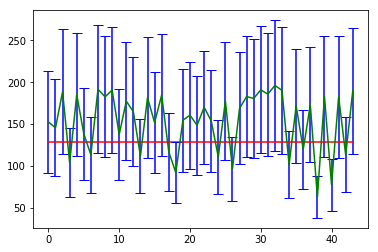

ReducedChiSquared: 0.6192582744744337


In [33]:
popt, pcov = curve_fit(costante, range(len(soglie)), soglie, sigma=err_soglie)
cost_red_chisq = cost_chiquadronorm(soglie, costante(range(len(soglie)),*popt), err_soglie, len(soglie)-len(popt), norm=True)
plt.plot(range(len(soglie)), [costante(range(len(soglie)),*popt) for k in range(len(soglie))], color='r')
plt.errorbar(range(len(soglie)), soglie, yerr=err_soglie,solid_capstyle='projecting',capsize=5,ecolor='blue',color='green')
plt.show()
print('ReducedChiSquared:', cost_red_chisq)

In [34]:
np.sqrt(pcov)

array([[6.37949449]])

In [35]:
popt

array([128.77802517])

In [36]:
media_pesata_soglie = media_pesata(soglie, err_soglie)
errore_media_soglia = np.sqrt(np.sum((soglie - media_pesata_soglie)**2)/(len(soglie)*(len(soglie)-1)))
print(media_pesata_soglie, errore_media_soglia)

128.77802517036957 6.633983699986502


**Ho, come nel caso precedente dove consideravo meno rivolte, valori di soglia compatibili con un valore costante.  
Questo però dopo aver applicato la funzione isola_spikes e selezionato gli spike da definire come 'rivolte' come quelli con numero di attivi + errore almeno uguali a soglia - errore.**  
Non posso vedere se tutti gli spike vanno bene (per rifare il calcolo del valore di soglia anche in questo caso con più rivolte) perchè la selezione da spike a rivolta la faccio prima di trovare i parametri dei fit e i parametri del fit li uso per calcolare le soglie con i loro errori

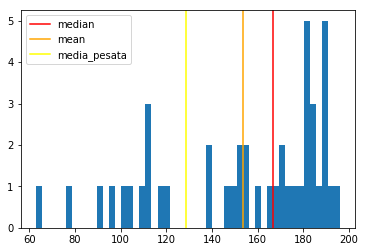

In [37]:
plt.hist(soglie, bins=50)
plt.axvline(np.median(soglie), c='red', label='median')
plt.axvline(np.mean(soglie), c='orange', label='mean')
plt.axvline(media_pesata_soglie, c='yellow', label='media_pesata')
plt.legend()
plt.show()